# Time Series Forecasting with NimbusML

In [162]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from nimbusml import Pipeline
from nimbusml.timeseries import SsaForecaster

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [163]:
# Load image summary data from github
url_to_csv = "https://raw.githubusercontent.com/mstfbl/NimbusML-Samples/Issue-22/datasets/max_planck_weather_time_series_dataset.csv"
df_train = pd.read_csv(filepath_or_buffer=url_to_csv, sep = ",",)

Let's look at our data.

In [164]:
df_train.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30


In [165]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [166]:
TRAIN_SPLIT = 300000

In [167]:
data_univariate = df_train['T (degC)']
data_univariate.index = df_train['Date Time']
data_univariate.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E99E9A4A88>],
      dtype=object)

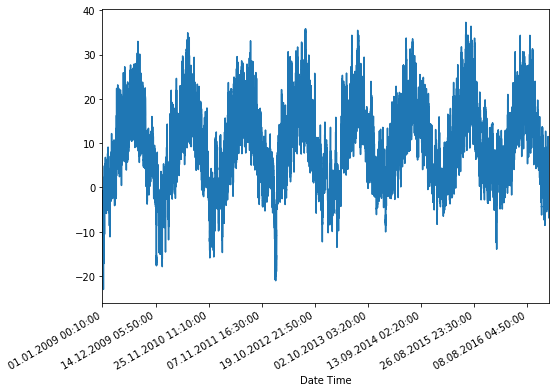

In [168]:
data_univariate.plot(subplots=True)

In [169]:
data_univariate = data_univariate.values
data_univariate_mean = data_univariate[:TRAIN_SPLIT].mean()
data_univariate_std = data_univariate[:TRAIN_SPLIT].std()
data_univariate = (data_univariate-data_univariate_mean)/data_univariate_std

In [171]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(data_univariate, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(data_univariate, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [172]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [173]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [174]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\mubal\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

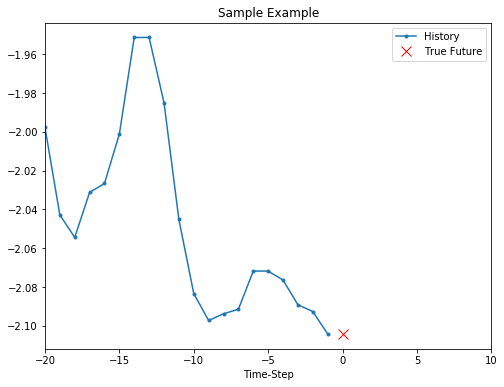

In [175]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [176]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\mubal\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

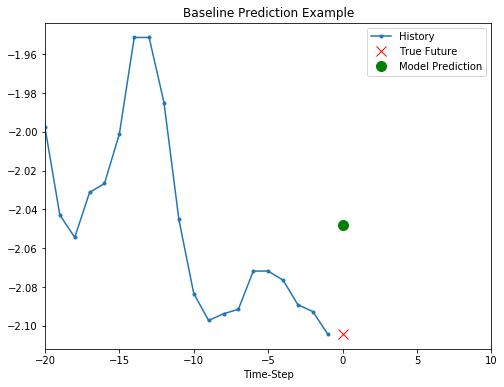

In [177]:
#print(x_train_uni[0])
#print(y_train_uni[0])
#print(baseline(x_train_uni[0]))
#print(x_train_uni.shape[-2:])
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

In [178]:
x_train_uni_list = [x[0] for x in x_train_uni[0].tolist()]
X_train_ssa = pd.Series(x_train_uni_list, name="T (degC)")
print(X_train_ssa)

0    -2.00
1    -2.04
2    -2.05
3    -2.03
4    -2.03
5    -2.00
6    -1.95
7    -1.95
8    -1.98
9    -2.05
10   -2.08
11   -2.10
12   -2.09
13   -2.09
14   -2.07
15   -2.07
16   -2.08
17   -2.09
18   -2.09
19   -2.10
Name: T (degC), dtype: float64


In [179]:
pipeline = Pipeline([
    SsaForecaster(series_length=6,
                  train_size=8,
                  window_size=3,
                  horizon=2,
                  columns={'T (degC)_fc': 'T (degC)'})
])

In [180]:
pipeline.fit(X_train_ssa)
print(X_train_ssa)

Elapsed time: 00:00:00.0282690
0    -2.00
1    -2.04
2    -2.05
3    -2.03
4    -2.03
5    -2.00
6    -1.95
7    -1.95
8    -1.98
9    -2.05
10   -2.08
11   -2.10
12   -2.09
13   -2.09
14   -2.07
15   -2.07
16   -2.08
17   -2.09
18   -2.09
19   -2.10
Name: T (degC), dtype: float64


In [187]:
result = pipeline.transform(X_train_ssa)
#plot = show_plot([x_train_uni[0], y_train_uni[0], pipeline.predict(x_train_uni[0])], 0, 'Simple SSA Forecaster model')
#plot.show()
print(result)

    T (degC)  T (degC)_fc.0  T (degC)_fc.1
0      -2.00          -1.97          -1.96
1      -2.04          -2.04          -2.03
2      -2.05          -2.05          -2.03
3      -2.03          -2.02          -2.00
4      -2.03          -2.00          -1.98
5      -2.00          -1.99          -1.96
6      -1.95          -1.93          -1.91
7      -1.95          -1.92          -1.90
8      -1.98          -1.97          -1.95
9      -2.05          -2.03          -2.03
10     -2.08          -2.08          -2.07
11     -2.10          -2.09          -2.07
12     -2.09          -2.08          -2.06
13     -2.09          -2.07          -2.05
14     -2.07          -2.05          -2.03
15     -2.07          -2.05          -2.03
16     -2.08          -2.06          -2.04
17     -2.09          -2.07          -2.06
18     -2.09          -2.08          -2.06
19     -2.10          -2.09          -2.07


In [ ]:
pipeline.predict()
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(result)